CIFAR10 - WideResnet solution. Adaptación de https://www.kaggle.com/zjaume/resnet-cifar10

Install Keras just in case...

In [ ]:
!pip3 install keras
!pip3 install keras_applications

     |████████████████████████████████| 51kB 4.3MB/s 


Imports...

In [ ]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Conv2D, Add, ZeroPadding2D
from keras.layers.normalization import BatchNormalization as  BN
from keras.layers.merge import add
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
import keras.backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import utils

import numpy as np

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from keras.datasets import cifar10

import keras

Define batch size, number of epochs and number of classes


In [ ]:
batch_size = 100
num_classes = 10
epochs = 75

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
## Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3,
    rotation_range=45,
    vertical_flip=False)

Movidas

In [ ]:
def bn_act(x, activation='relu'):
    l = BN()(x)
    if activation=='prelu':
        l = PReLU()(l)
    else:
        l = Activation('relu')(l)
    return l

In [ ]:
def res_block(convs, identity=True, k=1):
    def inner(x):
        if not identity:
            strides = (2,2)
        else:
            strides = (1,1)
            
        act = bn_act(x)
        l = Conv2D(convs*k, 3, strides=strides, padding='same', kernel_initializer='he_normal')(act)
        
        l = bn_act(l)
        l = Dropout(0.5)(l)
        l = Conv2D(convs*k, 3, strides=(1,1), padding='same', kernel_initializer='he_normal')(l)
        
        if not identity or x.shape[3]!=convs*k:
            shortcut = Conv2D(convs*k, 1, strides=strides, padding='same', kernel_initializer='he_normal')(act)
            l = Add()([l,shortcut])
        else:
            l = Add()([l,x])
        return l
    return inner

In [ ]:
def wide_resnet(input_shape, k=8):
    inpt = Input(shape = input_shape)

    # stage 1
    x = Conv2D(16, 3, strides=(1,1), padding='same', kernel_initializer='he_normal')(inpt)
    #x = bn_act(x)
    #x = MaxPooling2D(pool_size=(3,3),strides=2)(x)
    
    n=28 # depth or total number of layers
    N = (n-4)//6
    # stage 2
    for i in range(N):
        x = res_block(16,k=k)(x)

    # stage 3
    x = res_block(32,False,k=k)(x)
    for i in range(1,N):
        x = res_block(32,k=k)(x)

    # stage 4
    x = res_block(64,False,k=k)(x)
    for i in range(1,N):
        x = res_block(64,k=k)(x)
    
    x = bn_act(x)
    x = GlobalAveragePooling2D()(x)
    outpt = Dense(num_classes, activation="softmax")(x)
    model = Model(inpt,outpt)

    return model

In [ ]:
model = wide_resnet(x_train.shape[1:], k=4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Define an optimizer 

In [ ]:
opt = SGD(lr=0.1, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


DEFINE A LEARNING RATE SCHEDULER

In [ ]:
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

# Callbacks
set_lr = LRS(scheduler)
es = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Compile the model, define loss and link the optimizer

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Finally, train the model and evaluate over the test data

In [ ]:
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                  steps_per_epoch=len(x_train) / batch_size, 
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  callbacks=[set_lr, es],
                  verbose=1)

# Evaluate over test
score = model.evaluate(x_test, y_test, verbose=0)


print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/75
500/500 [==============================] - 128s 155ms/step - loss: 2.0324 - accuracy: 0.2346 - val_loss: 2.4537 - val_accuracy: 0.2751
Epoch 2/75
500/500 [==============================] - 76s 151ms/step - loss: 1.7129 - accuracy: 0.3677 - val_loss: 2.0598 - val_accuracy: 0.3714
Epoch 3/75
500/500 [==============================] - 76s 152ms/step - loss: 1.5899 - accuracy: 0.4163 - val_loss: 2.0856 - val_accuracy: 0.3812
Epoch 4/75
500/500 [==============================] - 76s 152ms/step - loss: 1.4797 - accuracy: 0.4633 - val_loss: 1.8285 - val_accuracy: 0.4447
Epoch 5/75
500/500 [==============================] - 76s 152ms/step - loss: 1.3950 - accuracy: 0.4931 - val_loss: 1.5027 - val_accuracy: 0.4938
Epoch 6/75
500/500 [==============================] - 76s 152ms/step - loss: 1.3256 - accuracy: 0.5235 - val_loss: 1.6666 - val_accuracy: 0.4749
Epoch 7/75
500/500 [==============================] - 76s 152ms/step - loss: 1.2513 - accuracy: 0.5523 - val_loss: 1.4724 - val_a

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [ ]:
import matplotlib.pyplot as plt

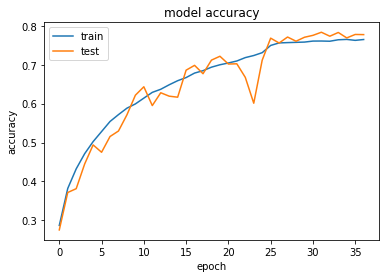

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()